# STAT 201 Project Proposal
### Group 16

## 2. Preliminary Results

We begin by loading the necessary R libraries for data wrangling and statistical inference.

In [1]:
library(cowplot)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(broom)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




Next, we read the data from CSV files downloaded from the Vancouver Police Department (https://geodash.vpd.ca/opendata/) for the years 2018-2022 in the neighbourhood West Point Grey. We combine the data across all five years into a single data frame, and select only the columns of interest, which in this case are those that represent the type of crime and the date and time the crime took place.

In [2]:
west_point_grey_2018 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2018.csv", show_col_types = FALSE)
west_point_grey_2019 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2019.csv", show_col_types = FALSE)
west_point_grey_2020 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2020.csv", show_col_types = FALSE)
west_point_grey_2021 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2021.csv", show_col_types = FALSE)
west_point_grey_2022 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2022.csv", show_col_types = FALSE)

wpg <- rbind(
    west_point_grey_2018, 
    west_point_grey_2019,
    west_point_grey_2020,
    west_point_grey_2021,
    west_point_grey_2022
) |>
    mutate(TYPE = as.factor(TYPE)) |>
    select(TYPE, YEAR, MONTH, DAY, HOUR)

head(wpg)

TYPE,YEAR,MONTH,DAY,HOUR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Break and Enter Commercial,2018,5,18,18
Break and Enter Commercial,2018,5,29,23
Break and Enter Commercial,2018,9,25,14
Break and Enter Commercial,2018,11,9,18
Break and Enter Commercial,2018,9,17,12
Break and Enter Commercial,2018,2,2,14


Next, we divide the data into two data frames representing our time periods of interest: the first contains data from March 2018-Feb 2020, the two years before the COVID-19 pandemic, and the second contains data from March 2020-Feb 2022, the two years after the pandemic. Summary tables for each period are below, and show the number of each type of crime.

In [3]:
wpg_precovid <- wpg |>
    filter((YEAR == 2018 & MONTH > 2) | YEAR == 2019 | (YEAR == 2020 & MONTH < 3))

wpg_covid <- wpg |>
    filter((YEAR == 2020 & MONTH > 2) | YEAR == 2021 | (YEAR == 2022 & MONTH < 3))

wpg_precovid_by_type <- wpg_precovid |>
    group_by(TYPE) |>
    summarize(n = n())

wpg_covid_by_type <- wpg_covid |>
    group_by(TYPE) |>
    summarize(n = n())

In [4]:
wpg_precovid_by_type

TYPE,n
<fct>,<int>
Break and Enter Commercial,27
Break and Enter Residential/Other,131
Mischief,106
Offence Against a Person,34
Other Theft,124
Theft from Vehicle,340
Theft of Bicycle,62
Theft of Vehicle,26
Vehicle Collision or Pedestrian Struck (with Fatality),1


(Figure 1a. Crimes in West Point Grey, 03/2018-02/2020)

In [5]:
wpg_covid_by_type

TYPE,n
<fct>,<int>
Break and Enter Commercial,27
Break and Enter Residential/Other,157
Homicide,1
Mischief,88
Offence Against a Person,39
Other Theft,120
Theft from Vehicle,266
Theft of Bicycle,44
Theft of Vehicle,15


(Figure 1b. Crimes in West Point Grey, 03/2020-02/2022)

Next, we calculate summary statistics for the proportion of break and enter crimes across both time periods.

In [6]:
# wpg_summary <- wpg_precovid |>
#     summarize(prop = prop(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other"))
set.seed(2023)

bootstrap_reps = 1000

precovid_sample_size = nrow(wpg_precovid)
covid_sample_size = nrow(wpg_covid)

group_col <- c("Pre-COVID", "COVID")
n_break_col <- c(nrow(wpg_precovid |> filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other")),
                 nrow(wpg_covid |> filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other")))
n_total_col <- c(precovid_sample_size, covid_sample_size)
prop_col <- c(n_break_col[1] / n_total_col[1],
              n_break_col[2] / n_total_col[2])

summary_tibble <- tibble(group_col, n_break_col, n_total_col, prop_col)
summary_tibble

group_col,n_break_col,n_total_col,prop_col
<chr>,<int>,<int>,<dbl>
Pre-COVID,158,882,0.1791383
COVID,184,780,0.2358974


In [7]:
z_test <- tidy(prop.test(
    x = n_break_col,
    n = n_total_col,
    correct = FALSE
    ))
z_test

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.1791383,0.2358974,8.159535,0.004283536,1,-0.09585096,-0.01766727,2-sample test for equality of proportions without continuity correction,two.sided


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



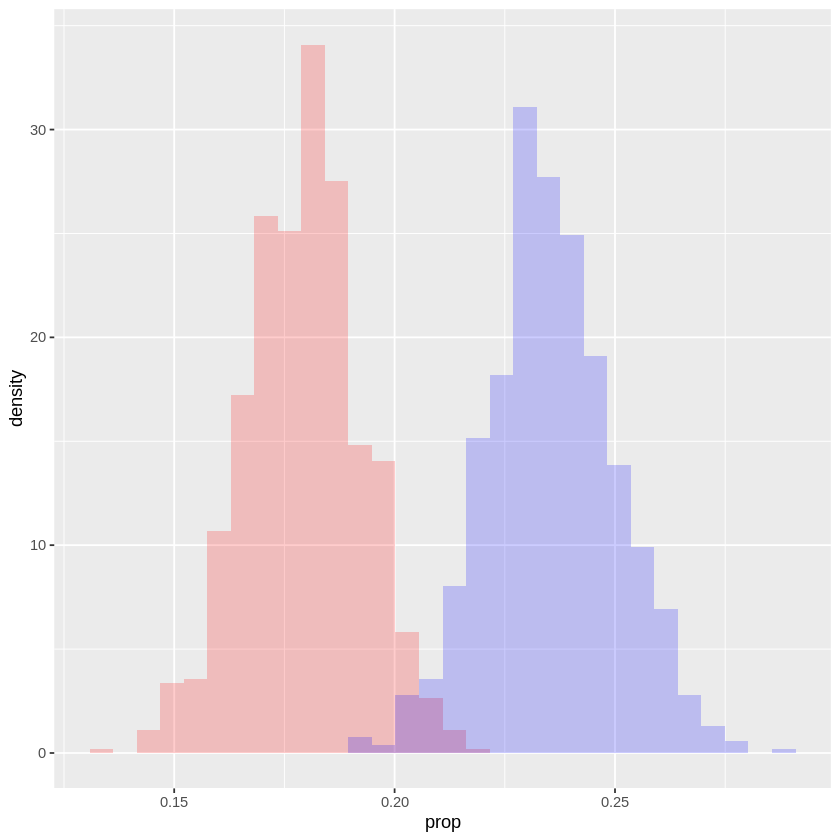

In [8]:
wpg_precovid_bootstrap <- wpg_precovid |>
    rep_sample_n(size = precovid_sample_size, reps = bootstrap_reps, replace = TRUE) |>
    count(TYPE) |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    group_by(replicate) |>
    summarize(count = sum(n)) |>
    mutate(prop = count / precovid_sample_size)

wpg_covid_bootstrap <- wpg_covid |>
    rep_sample_n(size = covid_sample_size, reps = bootstrap_reps, replace = TRUE) |>
    count(TYPE) |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    group_by(replicate) |>
    summarize(count = sum(n)) |>
    mutate(prop = count / covid_sample_size)

wpg_bootstrap_dist <- 
    ggplot() +
    geom_histogram(data = wpg_precovid_bootstrap, aes(prop, ..density..), fill = "red", alpha = 0.2) +
    geom_histogram(data = wpg_covid_bootstrap, aes(prop, ..density..), fill = "blue", alpha = 0.2)
    
wpg_bootstrap_dist